<h1 align="center"><font size="5"><b>数据挖掘大作业项目：有监督机器学习 - 分类</b></font></h1>

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# 1. 关于数据

**数据来源**

[Kaggle](https://www.kaggle.com/c/titanic/data)

**数据描述**

泰坦尼克号沉没事件是历史上最著名的船难之一。1912年4月15日，在其处女航期间，被广泛认为“永不沉没”的RMS泰坦尼克号在与冰山相撞后沉没。不幸的是，船上没有足够的救生艇，导致2224名乘客和船员中有1502人遇难。虽然在生还中存在一定的运气成分，但似乎某些群体的人更有可能生还。在本次挑战中，我们希望你构建一个预测模型，来回答这样一个问题：“哪类人更有可能生还？”你将使用乘客数据（如姓名、年龄、性别、社会经济阶层等）来实现这一目标。

---

数据被划分为两组：

- 训练集（train.csv）

- 测试集（test.csv）

训练集用于构建机器学习模型。训练集中的每位乘客提供了最终结果（也就是“真实标签”）。模型将基于如乘客性别、舱位等特征进行训练。

测试集用于评估模型在未见数据上的表现。测试集中未提供每位乘客的生还情况，任务是使用训练好的模型来预测他们是否在这场海难中幸存。



**数据字典**

| 变量      | 定义                         | 取值                                      |
|-----------|------------------------------|-------------------------------------------|
| survival  | 生存情况                     | $0$ = 否，$1$ = 是                        |
| pclass    | 舱位等级                     | $1$ = 一等舱，$2$ = 二等舱，$3$ = 三等舱  |
| sex       | 性别                         |                                           |
| age       | 年龄                         | 单位：岁                                  |
| sibsp     | 堂/兄妹及配偶数量            |                                           |
| parch     | 父母/子女数量                |                                           |
| ticket    | 船票编号                     |                                           |
| fare      | 票价                         | 单位：英镑                                |
| cabin     | 舱房编号                     |                                           |
| embarked  | 登船港口                     | $C$ = 瑟堡 (Cherbourg),<br>$Q$ = 皇后镇 (Queenstown),<br>$S$ = 南安普敦 (Southampton) |

---

**变量说明**

1. $\mathbf{pclass}$：社会经济地位（SES）的代理变量  
   - $1$ = 上层  
   - $2$ = 中层  
   - $3$ = 下层  

2. $\mathbf{age}$：  
   - 若小于 1 岁，则以小数形式表示，如 $0.42$ 表示 5 个月  
   - 若为估计值，则以“.5”结尾，如 $30.5$ 表示估计 30.5 岁  

3. $\mathbf{sibsp}$：  
   - 兄弟姐妹：兄弟、姐妹、同父异母兄弟、同母异父姐妹  
   - 配偶：丈夫、妻子（不包括情妇和未婚夫/妻）  

4. $\mathbf{parch}$：  
   - 父母：母亲、父亲  
   - 子女：女儿、儿子、继女、继子  
   - 部分儿童仅与保姆同行，因此此类情况下 $parch=0$

Importing Dataset:

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [16]:
df = pd.read_csv('datasets/titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**注意**：

- **Cabin** 特征缺失值过多，所以在本次分析中将 **排除** 该特征。  
- **Age** 特征也存在缺失值，但数量相对较少，所以考虑对其进行 **插补**（imputation）。  
- **Embarked** 列仅有 2 个缺失值，所以考虑 **删除** 对应行，不会对训练造成显著影响。  

In [22]:
df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


# 2. 目标

本次分析的主要目标是构建一个预测模型，准确判断泰坦尼克号乘客是否生还。重点在于 **预测**（prediction），即最大化模型在分类生存结果上的 **准确率**（accuracy），而非解释变量之间的内在关系。评估的主要指标是 **准确率**（accuracy），以确保模型对尽可能多的乘客生存状态进行正确预测。


# 3. 模型

## a. 数据清理

In [31]:
# Dropping irrelevant features
df_drop = df.drop(columns=['Name', 'Ticket', 'Cabin'])
df_drop

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [18]:
# Checking for null values
df_drop.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

In [70]:
# Drop 2 missing values in 'Embarked' column
df_drop1 = df_drop.copy()
df_drop1 = df_drop.dropna(subset=['Embarked'])
df_drop1.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

In [71]:
# Imputating missing values in 'Age' column with median
df_imputate = df_drop1.copy()
df_imputate['Age'].fillna(df_imputate['Age'].median(), inplace=True)
df_imputate.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [77]:
# Age binning
df_bin = df_imputate.copy()
bins = [0, 12, 18, 35, 60, 80]
labels = ['child', 'teenager', 'young adult', 'adult', 'senior']
df_bin['Age_Bin'] = pd.cut(df_bin['Age'], bins=bins, labels=labels)
df_bin

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Bin
0,1,0,3,male,22.0,1,0,7.2500,S,young adult
1,2,1,1,female,38.0,1,0,71.2833,C,adult
2,3,1,3,female,26.0,0,0,7.9250,S,young adult
3,4,1,1,female,35.0,1,0,53.1000,S,young adult
4,5,0,3,male,35.0,0,0,8.0500,S,young adult
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S,young adult
887,888,1,1,female,19.0,0,0,30.0000,S,young adult
888,889,0,3,female,28.0,1,2,23.4500,S,young adult
889,890,1,1,male,26.0,0,0,30.0000,C,young adult


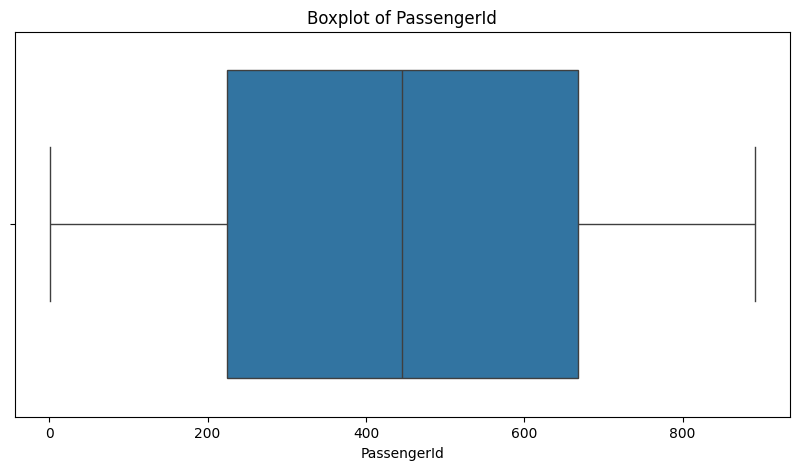

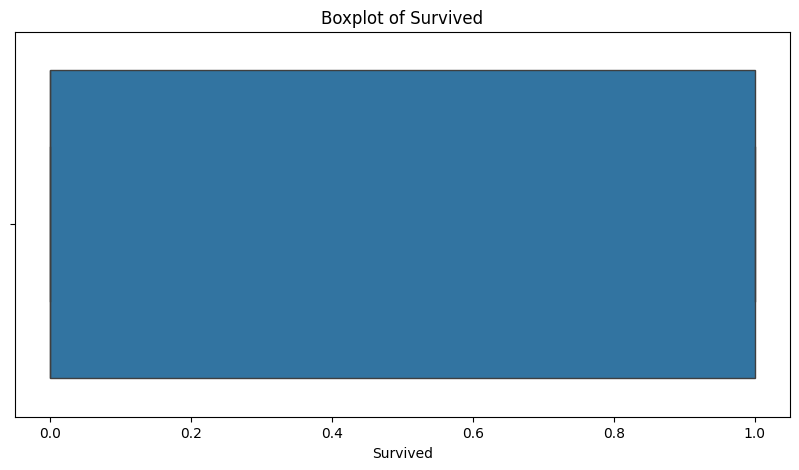

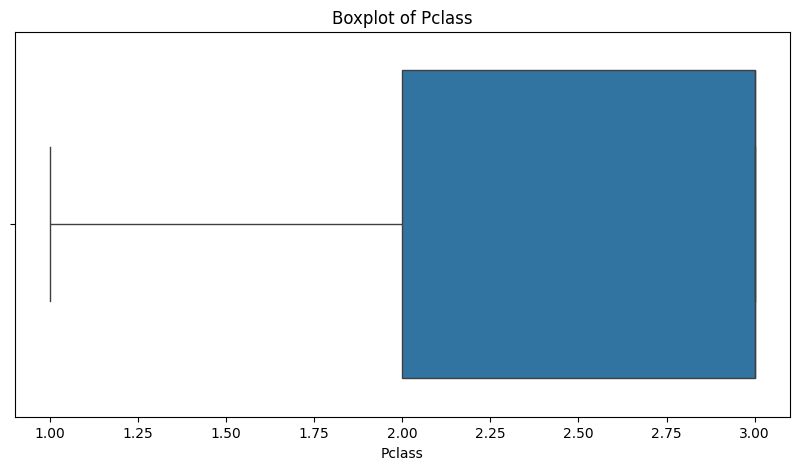

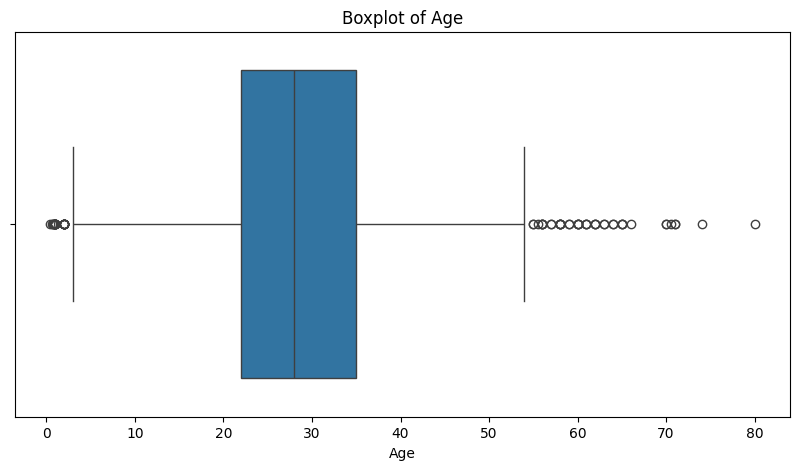

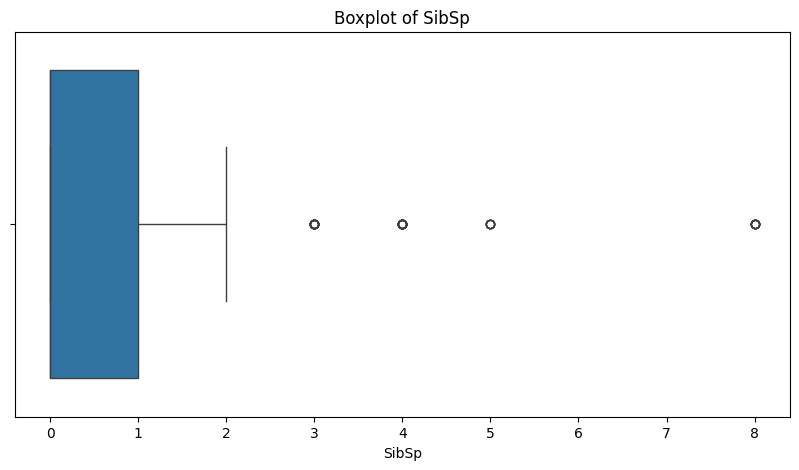

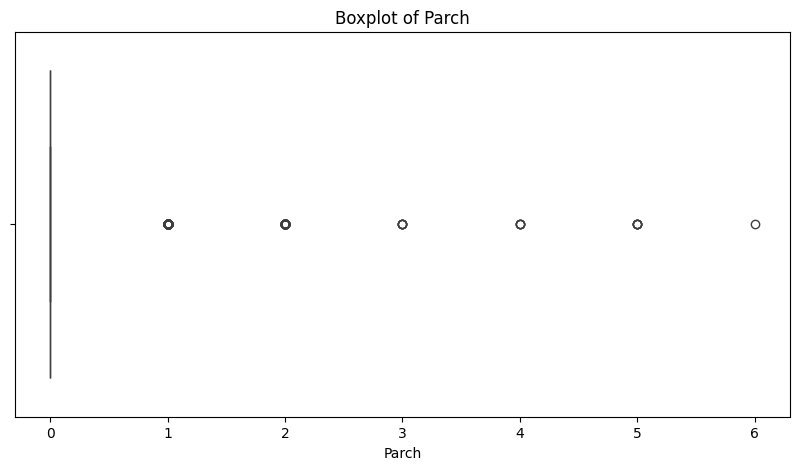

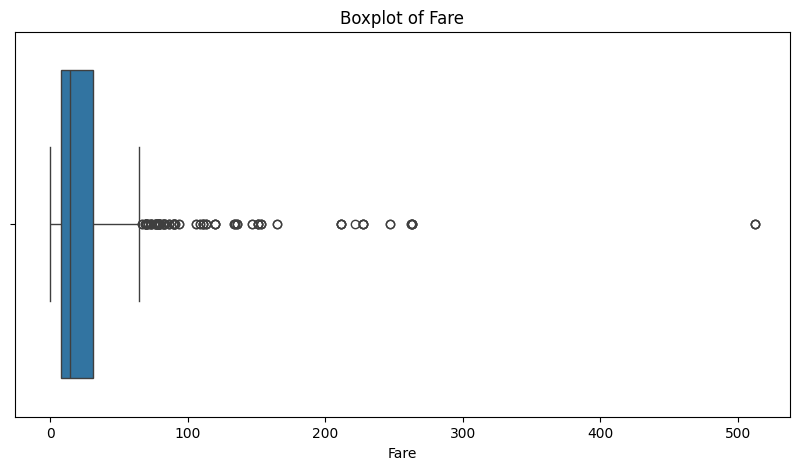

In [115]:
# Check for outliers in numerical features
numerical_features = df_bin.select_dtypes(include=[np.number]).columns.tolist()
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df_bin[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()


Note: The outlier seems not due to input errors and are valid data points, so I consider to keep the outliers, because the outliers might be meaningful and represent valid cases.

## b. EDA

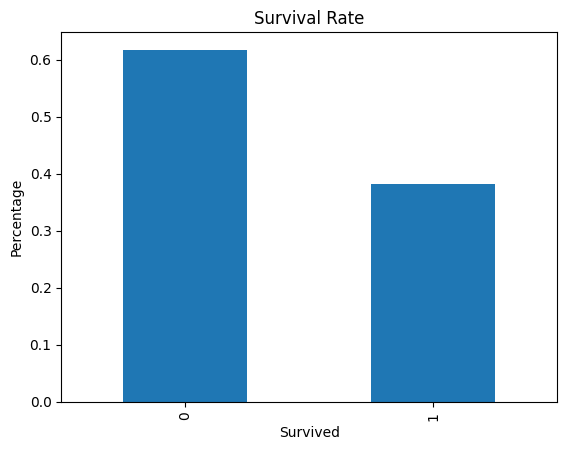

In [172]:
# Survival rate (Normalized)
df_bin['Survived'].value_counts(normalize=True).plot(kind='bar')
plt.title('Survival Rate')
plt.xlabel('Survived')
plt.ylabel('Percentage')
plt.show()

Note: 40% of passengers survived, while the remaining 60% did not. Therefore, the baseline accuracy of the model would be 60% if it always predicts that a passenger did not survive.

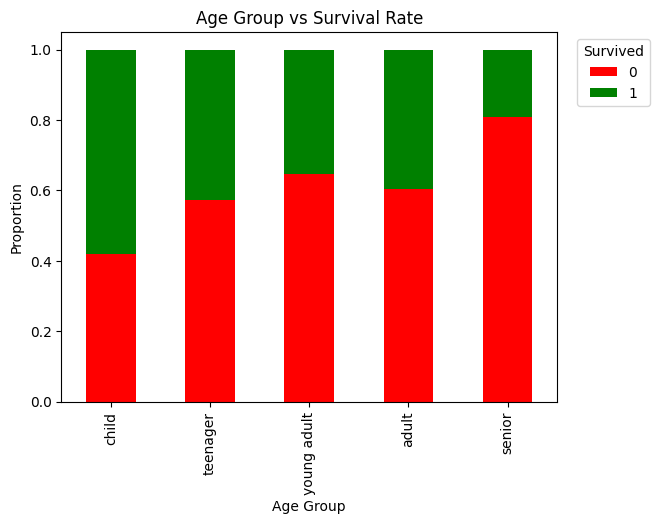

In [104]:
# Relationship between Age and Survival (Normalized
age_survival_rate = df_bin.groupby('Age_Bin')['Survived'].value_counts(normalize=True).unstack()
age_survival_rate.plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title('Age Group vs Survival Rate')
plt.xlabel('Age Group')
plt.ylabel('Proportion')
plt.legend(title='Survived', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Note: Children have the highest survival rate (almost 60%), which suggests that during the evacuation process, priority might have been given to children. This aligns with the "women and children first" protocol often followed in such emergencies. This insight highlights the importance of age as a significant factor in predicting survival on the Titanic.

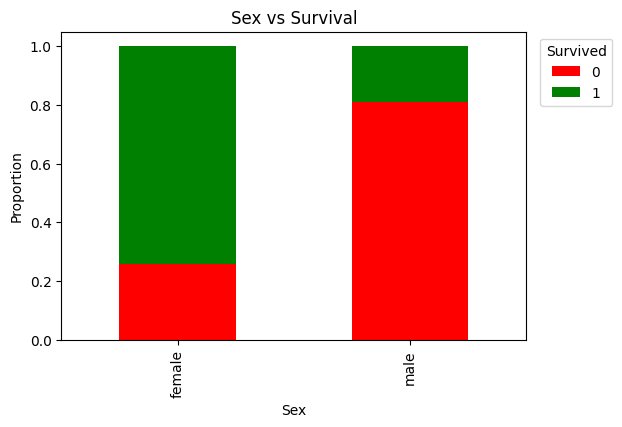

In [102]:
# Relationship between Sex and Survival (Normalized)
sex_survival_rate = df_bin.groupby('Sex')['Survived'].value_counts(normalize=True).unstack()
sex_survival_rate.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(6, 4))
plt.title('Sex vs Survival')
plt.xlabel('Sex')
plt.ylabel('Proportion')
plt.legend(title='Survived', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Note: Females have a high survival rate (about 75%), while males have only about 20% survival rate. This suggests that women were likely given priority during the evacuation process, consistent with the "women and children first" protocol often followed in such emergencies. Gender is therefore a significant factor in predicting survival on the Titanic.

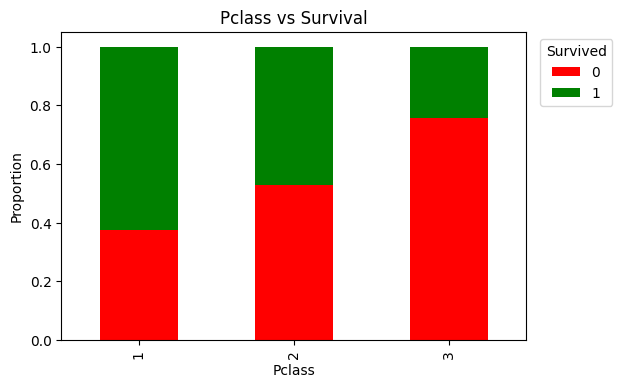

In [103]:
# Relationship between Pclass and Survival (Normalized)
pclass_survival_rate = df_bin.groupby('Pclass')['Survived'].value_counts(normalize=True).unstack()
pclass_survival_rate.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(6, 4))
plt.title('Pclass vs Survival')
plt.xlabel('Pclass')
plt.ylabel('Proportion')
plt.legend(title='Survived', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Note: The survival rate varies significantly across different passenger classes. First-class passengers have the highest survival rate, followed by second-class passengers, while third-class passengers have the lowest survival rate. This indicates that socio-economic status, as represented by passenger class, played a significant role in determining survival on the Titanic.

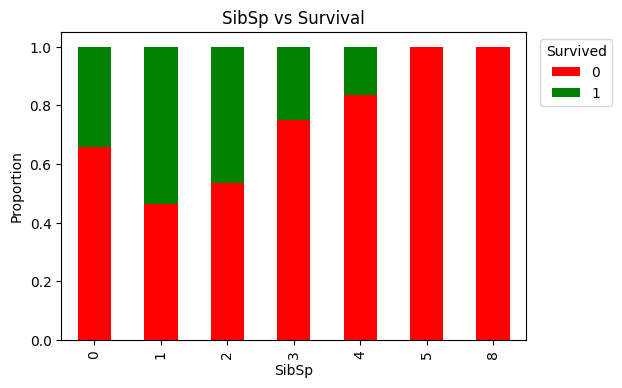

In [105]:
# Relationship between SibSp and Survival (Normalized)
sibsp_survival_rate = df_bin.groupby('SibSp')['Survived'].value_counts(normalize=True).unstack()
sibsp_survival_rate.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(6, 4))
plt.title('SibSp vs Survival')
plt.xlabel('SibSp')
plt.ylabel('Proportion')
plt.legend(title='Survived', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Passengers with 1 or 2 siblings/spouses aboard had a higher survival rate compared to those with no siblings/spouses or with more than 2. This suggests that having a small family group aboard may have positively influenced survival chances, possibly due to better coordination during the evacuation process.

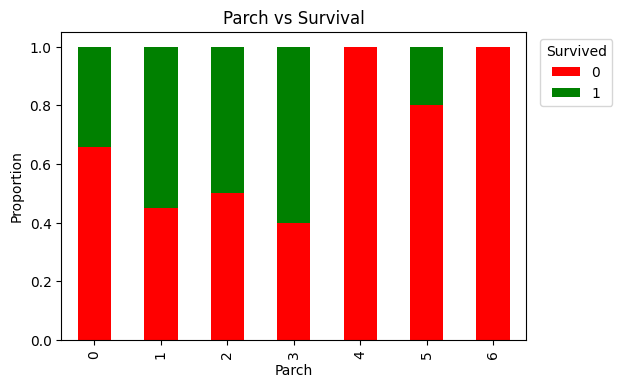

In [106]:
# Relationship between Parch and Survival (Normalized)
parch_survival_rate = df_bin.groupby('Parch')['Survived'].value_counts(normalize=True).unstack()
parch_survival_rate.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(6, 4))
plt.title('Parch vs Survival')
plt.xlabel('Parch')
plt.ylabel('Proportion')
plt.legend(title='Survived', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Passengers with 1 to 3 parents/children aboard had a higher survival rate compared to those with no parents/children or with more than 3. This suggests that having a small family group aboard may have positively influenced survival chances, possibly due to better coordination and support during the evacuation process.

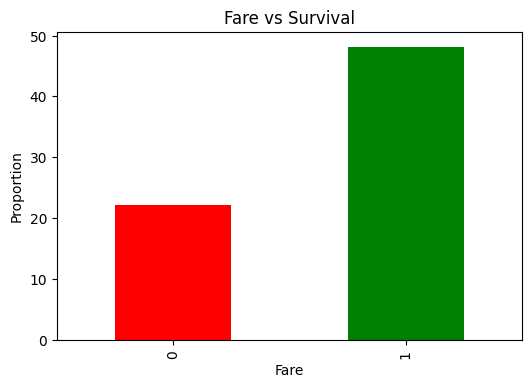

In [113]:
# Relationship between Fare and Survival
fare_survival_rate = df_bin.groupby('Survived')['Fare'].mean()
fare_survival_rate.plot(kind='bar', color=['red', 'green'], figsize=(6, 4))
plt.title('Fare vs Survival')
plt.xlabel('Fare')
plt.ylabel('Proportion')
plt.show()

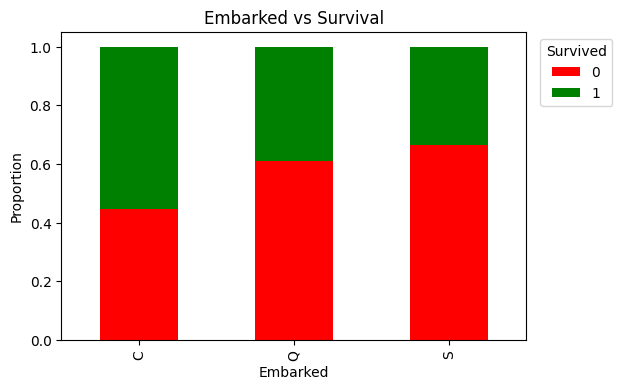

In [114]:
# Relationship between Embarked and Survival (Normalized)
embarked_survival_rate = df_bin.groupby('Embarked')['Survived'].value_counts(normalize=True).unstack()
embarked_survival_rate.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(6, 4))
plt.title('Embarked vs Survival')
plt.xlabel('Embarked')
plt.ylabel('Proportion')
plt.legend(title='Survived', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Note: Passengers who embarked at Cherbourg (C) had the highest survival rate, followed by those who embarked at Southampton (S), while passengers who embarked at Queenstown (Q) had the lowest survival rate. This suggests that the port of embarkation may have influenced survival chances, possibly due to differences in socio-economic status or cabin allocation among passengers from different ports.

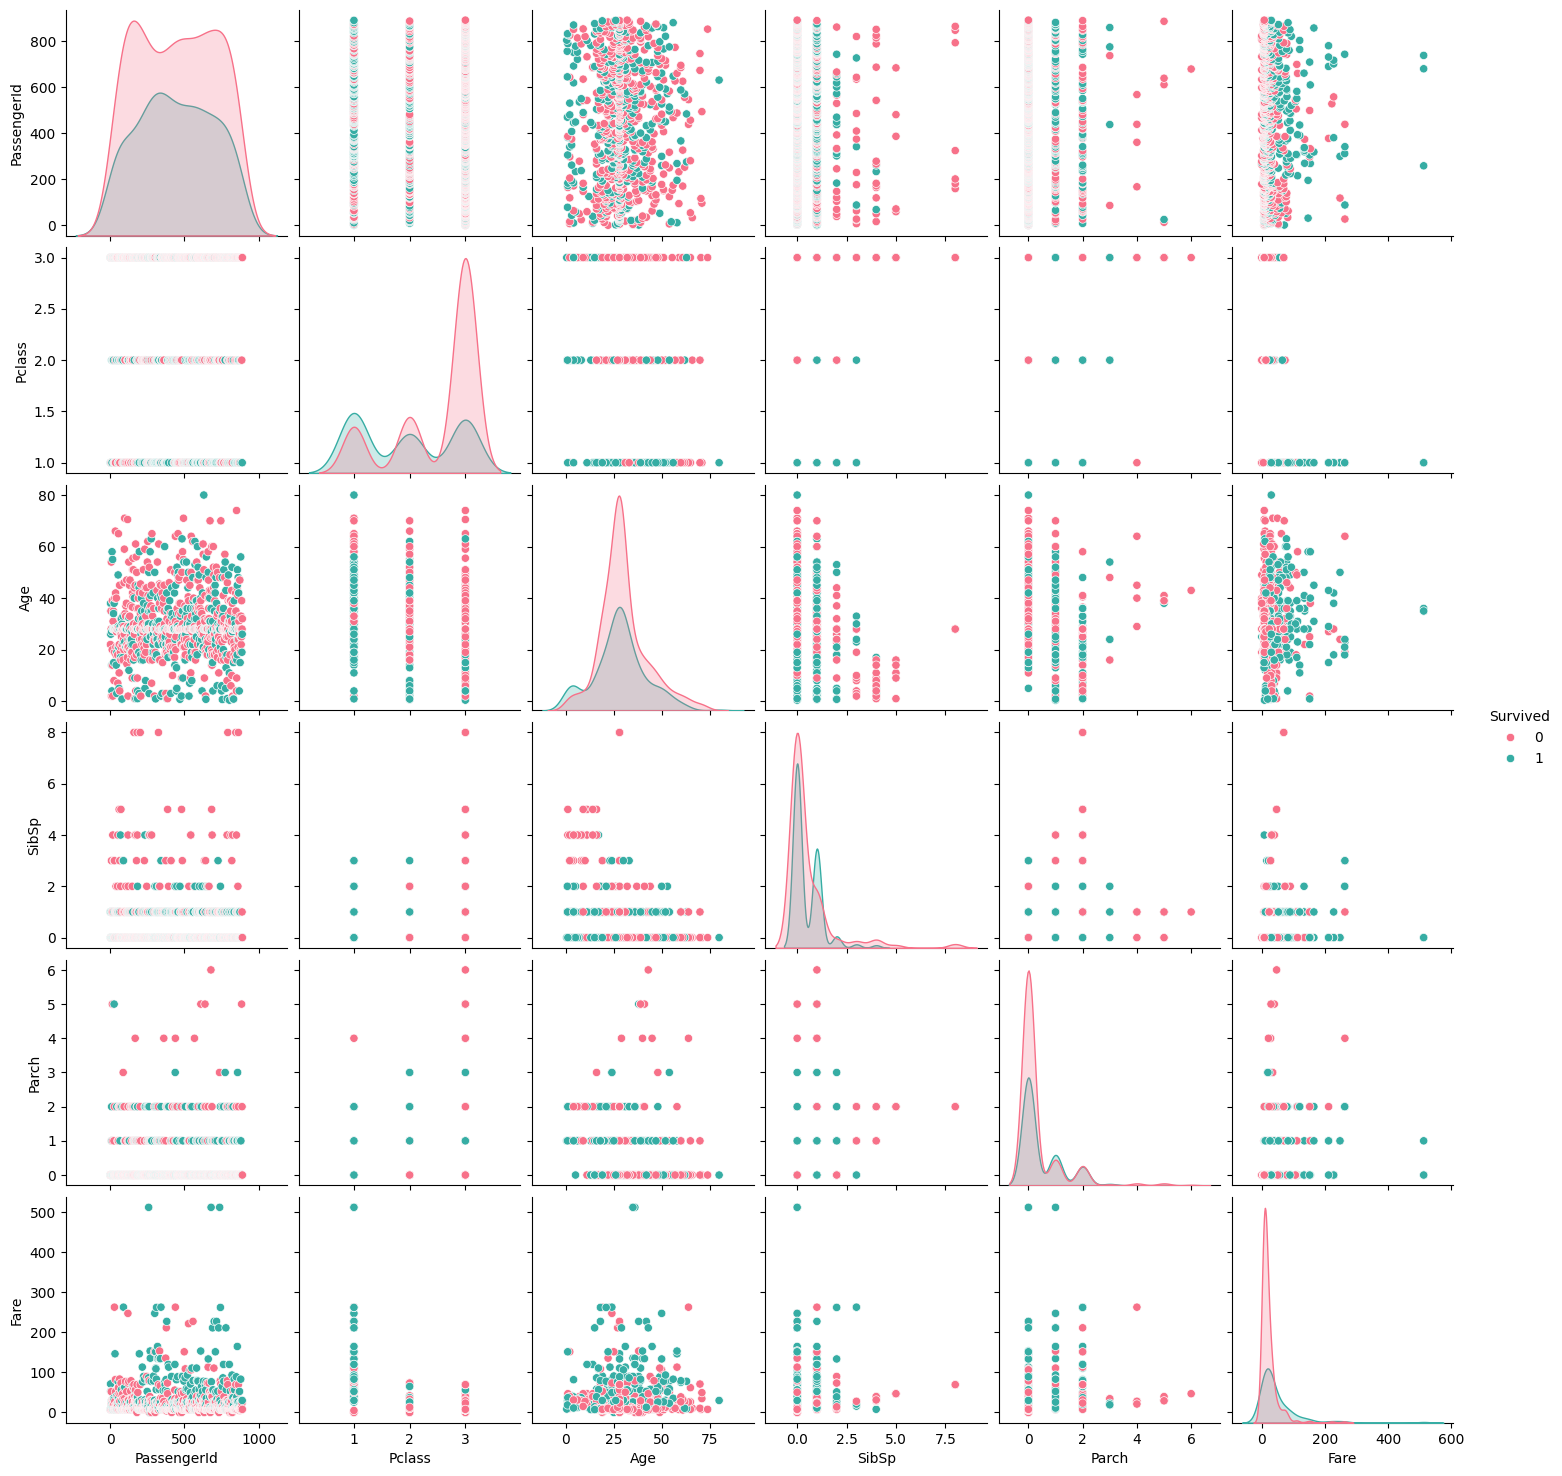

In [116]:
# Pairplot
sns.pairplot(df_bin, hue='Survived', diag_kind='kde', palette='husl')
plt.show()

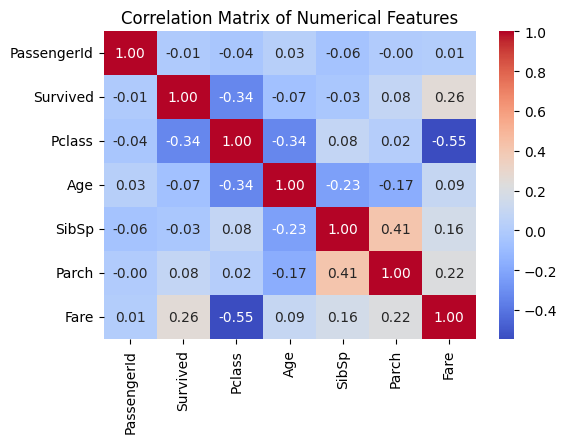

In [117]:
# Visualize correlation of numerical features
numerical_features = df_bin.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(6, 4))
sns.heatmap(df_bin[numerical_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [118]:
# Sort correlation features with respect to 'Survived'
correlation = df_bin[numerical_features].corr()['Survived'].abs().sort_values(ascending=False)[1:]
correlation

Pclass         0.335549
Fare           0.255290
Parch          0.083151
Age            0.069822
SibSp          0.034040
PassengerId    0.005028
Name: Survived, dtype: float64

## c. 特征构造

In [119]:
data_engineered = df_bin.copy()

# Create Family_Size feature basd on SibSp and Parch
data_engineered['Family_Size'] = data_engineered['SibSp'] + data_engineered['Parch'] + 1

# Create Is_Alone feature
data_engineered['Is_Alone'] = np.where(data_engineered['Family_Size'] == 1, 1, 0)

## d. 特征编码

In [121]:
data_engineered

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Bin,Family_Size,Is_Alone
0,1,0,3,male,22.0,1,0,7.2500,S,young adult,2,0
1,2,1,1,female,38.0,1,0,71.2833,C,adult,2,0
2,3,1,3,female,26.0,0,0,7.9250,S,young adult,1,1
3,4,1,1,female,35.0,1,0,53.1000,S,young adult,2,0
4,5,0,3,male,35.0,0,0,8.0500,S,young adult,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S,young adult,1,1
887,888,1,1,female,19.0,0,0,30.0000,S,young adult,1,1
888,889,0,3,female,28.0,1,2,23.4500,S,young adult,4,0
889,890,1,1,male,26.0,0,0,30.0000,C,young adult,1,1


In [122]:
data_engineered['Sex'].value_counts()

Sex
male      577
female    312
Name: count, dtype: int64

Note: Because there are only 2 categories, I would use Label Encoding.

In [123]:
data_engineered['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

Note: Because there are just 3 categories, I would also use Label Encoding.

In [126]:
# Encoding categorical features
data_encoded = data_engineered.copy()

sex_mapping = {"male": 1, "female": 0}
data_encoded["Sex"] = data_encoded["Sex"].map(sex_mapping)

embarked_mapping = {"C": 0, "Q": 1, "S": 2}
data_encoded["Embarked"] = data_encoded["Embarked"].map(embarked_mapping)

data_encoded

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Bin,Family_Size,Is_Alone
0,1,0,3,1,22.0,1,0,7.2500,2,young adult,2,0
1,2,1,1,0,38.0,1,0,71.2833,0,adult,2,0
2,3,1,3,0,26.0,0,0,7.9250,2,young adult,1,1
3,4,1,1,0,35.0,1,0,53.1000,2,young adult,2,0
4,5,0,3,1,35.0,0,0,8.0500,2,young adult,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,13.0000,2,young adult,1,1
887,888,1,1,0,19.0,0,0,30.0000,2,young adult,1,1
888,889,0,3,0,28.0,1,2,23.4500,2,young adult,4,0
889,890,1,1,1,26.0,0,0,30.0000,0,young adult,1,1


In [127]:
# Check the correlation with the target variable again
numerical_features = data_encoded.select_dtypes(include=[np.number]).columns
correlation = data_encoded[numerical_features].corr()['Survived'].abs().sort_values(ascending=False)[1:]
correlation

Sex            0.541585
Pclass         0.335549
Fare           0.255290
Is_Alone       0.206207
Embarked       0.169718
Parch          0.083151
Age            0.069822
SibSp          0.034040
Family_Size    0.018277
PassengerId    0.005028
Name: Survived, dtype: float64

Note: The new features after feature engineering and feature encoding do have a good correlation with the target variable, especially **Sex** (0.54), **Is_Alone** (0.21, which is better than Parch and SibSp), and **Embarked** (0.17)

In [128]:
# Drop irrelevant features
data_cleaned = data_encoded.copy()
data_cleaned = data_cleaned.drop(columns=['SibSp', 'Parch', 'Family_Size', 'Age_Bin'])
data_cleaned

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Is_Alone
0,1,0,3,1,22.0,7.2500,2,0
1,2,1,1,0,38.0,71.2833,0,0
2,3,1,3,0,26.0,7.9250,2,1
3,4,1,1,0,35.0,53.1000,2,0
4,5,0,3,1,35.0,8.0500,2,1
...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,13.0000,2,1
887,888,1,1,0,19.0,30.0000,2,1
888,889,0,3,0,28.0,23.4500,2,0
889,890,1,1,1,26.0,30.0000,0,1


## d. 训练-测试集划分

In [129]:
X = data_cleaned.drop(columns=['PassengerId', 'Survived'])
y = data_cleaned['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((711, 6), (178, 6), (711,), (178,))

## e. 数据缩放

In [131]:
# Exclude the categorical features from scaling
scaling_feature = ['Age', 'Fare']

s = StandardScaler()
X_train_s = X_train.copy()
X_test_s = X_test.copy()

X_train_s[scaling_feature] = s.fit_transform(X_train[scaling_feature])
X_test_s[scaling_feature] = s.transform(X_test[scaling_feature])

## f. 模型训练

In [133]:
def classification_report_highlighted(y_true, y_pred):
    """
    Prints a classification report with recall highlighted,
    as recall is the main objective.

    Args:
        y_true (array-like): True labels
        y_pred (array-like): Predicted labels
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')  # Change to 'macro' for multi-class
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    print("=" * 40)
    print("🔹 Classification Report")
    print("=" * 40)
    print(f"🚨 Accuracy   : \033[1m{accuracy:.4f}\033[0m  (Main Objective!)") # Highlight accuracy
    print(f"✅ Precision  : {precision:.4f}")
    print(f"✅ Recall     : {recall:.4f}")
    print(f"✅ F1 Score   : {f1:.4f}")
    print("=" * 40)

    # Print the full classification report
    print("\n🔹 Detailed Report:")
    print(classification_report(y_true, y_pred))

### 1) Logistic Regression

In [137]:
lr = LogisticRegression(random_state=42)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],       # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support l1 and l2 penalties
}

lr_gs = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

lr_gs.fit(X_train_s, y_train)
print("Best parameters found: ", lr_gs.best_params_)
print("Best cross-validation score: ", lr_gs.best_score_)

best_lr = lr_gs.best_estimator_
yhat = best_lr.predict(X_test_s)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score:  0.7918841721658623


In [138]:
classification_report_highlighted(y_test, yhat)

🔹 Classification Report
🚨 Accuracy   : 0.7978  (Main Objective!)
✅ Precision  : 0.7500
✅ Recall     : 0.7059
✅ F1 Score   : 0.7273

🔹 Detailed Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       110
           1       0.75      0.71      0.73        68

    accuracy                           0.80       178
   macro avg       0.79      0.78      0.78       178
weighted avg       0.80      0.80      0.80       178



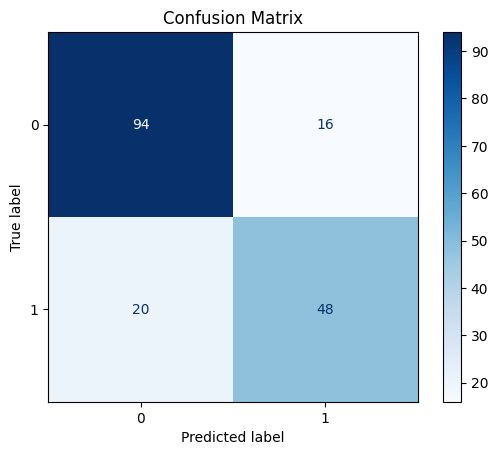

In [187]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_lr, X_test_s, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

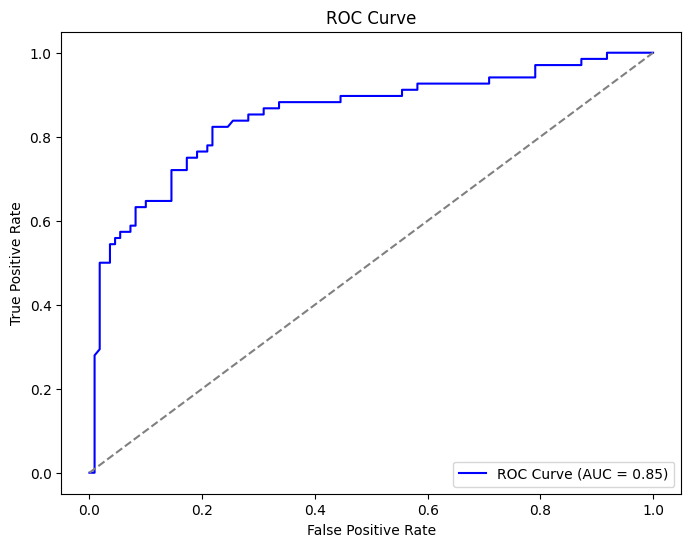

In [188]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_prob = best_lr.predict_proba(X_test_s)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

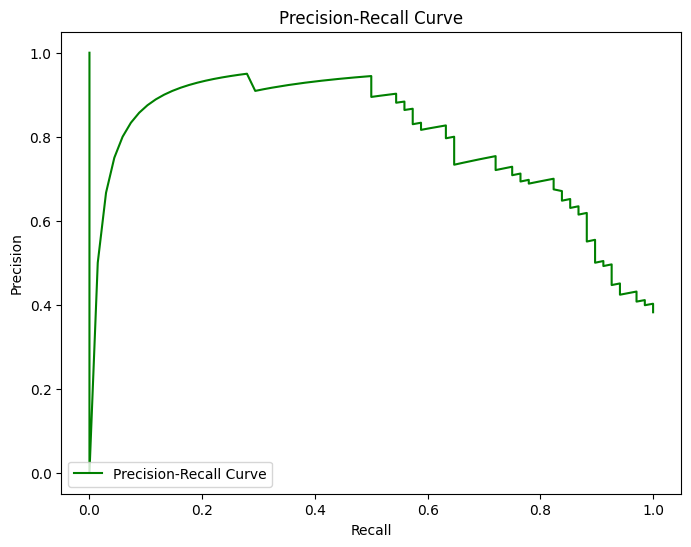

In [189]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

### 2) KNN

In [146]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

knn_gs = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

knn_gs.fit(X_train_s, y_train)
print("Best parameters found: ", knn_gs.best_params_)
print("Best cross-validation score: ", knn_gs.best_score_)

best_knn = knn_gs.best_estimator_
yhat = best_knn.predict(X_test_s)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Best cross-validation score:  0.7989067270757412


In [147]:
classification_report_highlighted(y_test, yhat)

🔹 Classification Report
🚨 Accuracy   : 0.7921  (Main Objective!)
✅ Precision  : 0.7460
✅ Recall     : 0.6912
✅ F1 Score   : 0.7176

🔹 Detailed Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       110
           1       0.75      0.69      0.72        68

    accuracy                           0.79       178
   macro avg       0.78      0.77      0.78       178
weighted avg       0.79      0.79      0.79       178



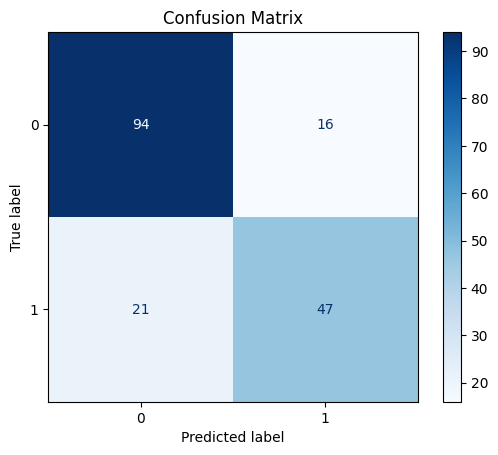

In [190]:
ConfusionMatrixDisplay.from_estimator(best_knn, X_test_s, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

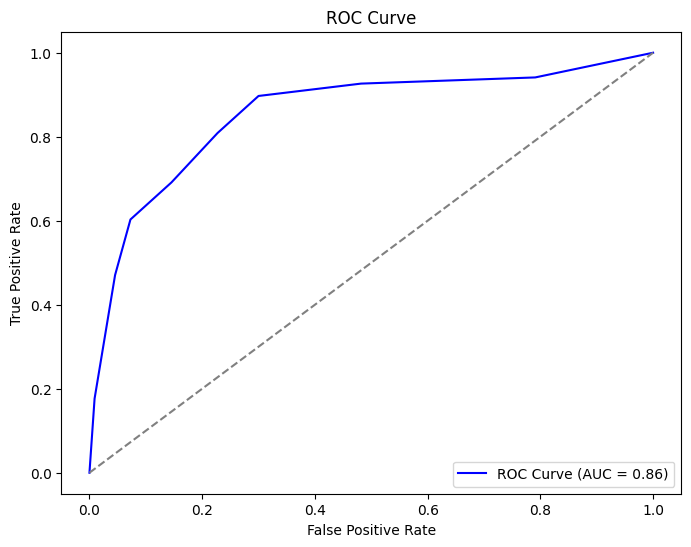

In [192]:
# Get predicted probabilities
y_prob = best_knn.predict_proba(X_test_s)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

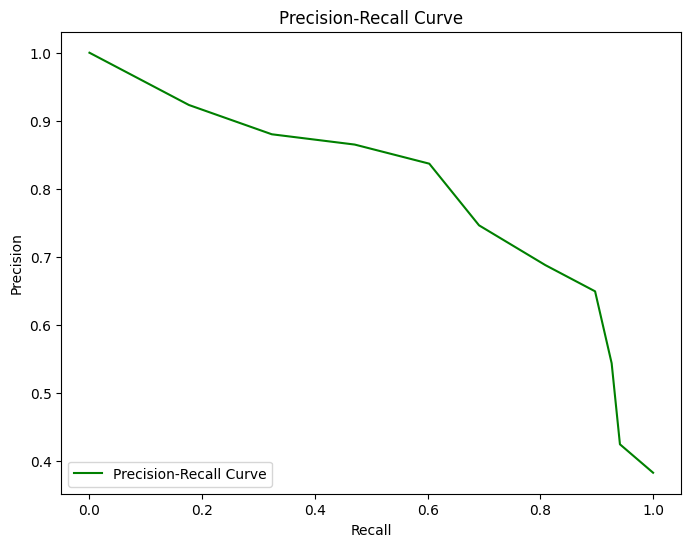

In [160]:
# Get predicted probabilities
y_prob = best_knn.predict_proba(X_test_s)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

### 3) SVC

In [152]:
svc = SVC(probability=True, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

svc_gs = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

svc_gs.fit(X_train_s, y_train)
print("Best parameters found: ", svc_gs.best_params_)
print("Best cross-validation score: ", svc_gs.best_score_)

best_svc = svc_gs.best_estimator_
yhat = best_svc.predict(X_test_s)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score:  0.8157391903870778


In [153]:
classification_report_highlighted(y_test, yhat)

🔹 Classification Report
🚨 Accuracy   : 0.8202  (Main Objective!)
✅ Precision  : 0.8750
✅ Recall     : 0.6176
✅ F1 Score   : 0.7241

🔹 Detailed Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       110
           1       0.88      0.62      0.72        68

    accuracy                           0.82       178
   macro avg       0.84      0.78      0.80       178
weighted avg       0.83      0.82      0.81       178



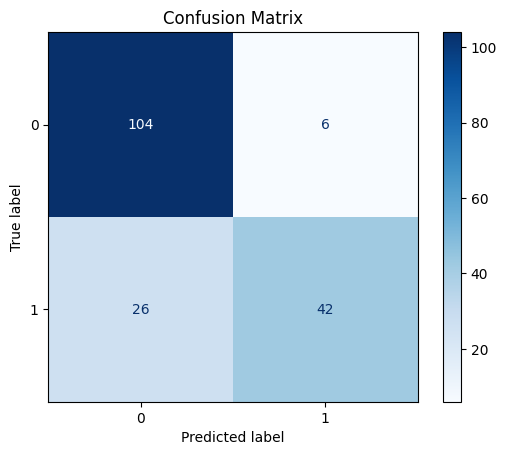

In [154]:
ConfusionMatrixDisplay.from_estimator(best_svc, X_test_s, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

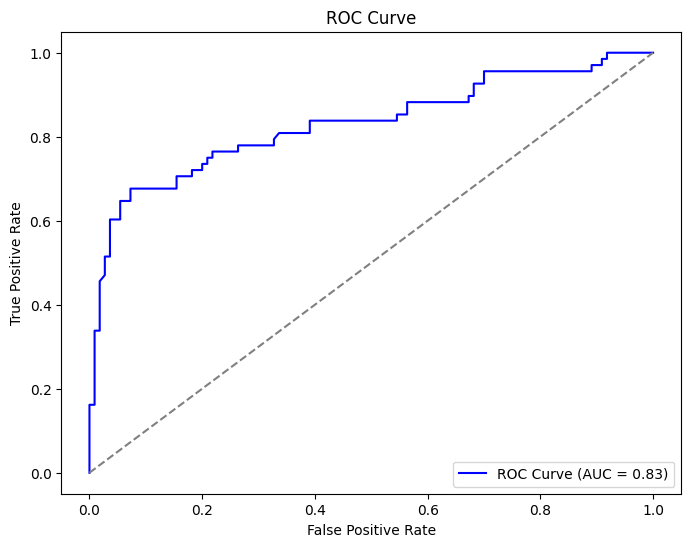

In [155]:
# Get predicted probabilities
y_prob = best_svc.predict_proba(X_test_s)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

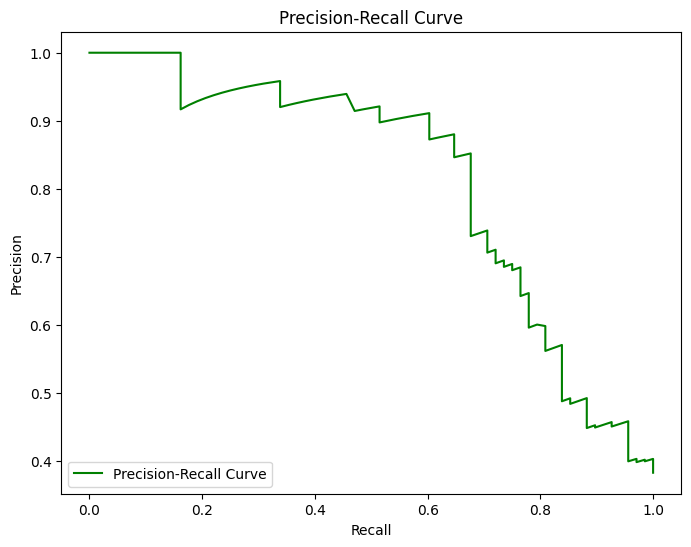

In [156]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

### 4) Random Forest

In [163]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']  # Number of features to consider when looking for the best split
}

# Perform GridSearchCV
rf_gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model
rf_gs.fit(X_train_s, y_train)

# Print the best parameters and the best cross-validation score
print("Best parameters found: ", rf_gs.best_params_)
print("Best cross-validation score: ", rf_gs.best_score_)

# Get the best estimator
best_rf = rf_gs.best_estimator_

# Make predictions
yhat = best_rf.predict(X_test_s)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation score:  0.824170196001182


In [164]:
classification_report_highlighted(y_test, yhat)

🔹 Classification Report
🚨 Accuracy   : 0.8202  (Main Objective!)
✅ Precision  : 0.8214
✅ Recall     : 0.6765
✅ F1 Score   : 0.7419

🔹 Detailed Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       110
           1       0.82      0.68      0.74        68

    accuracy                           0.82       178
   macro avg       0.82      0.79      0.80       178
weighted avg       0.82      0.82      0.82       178



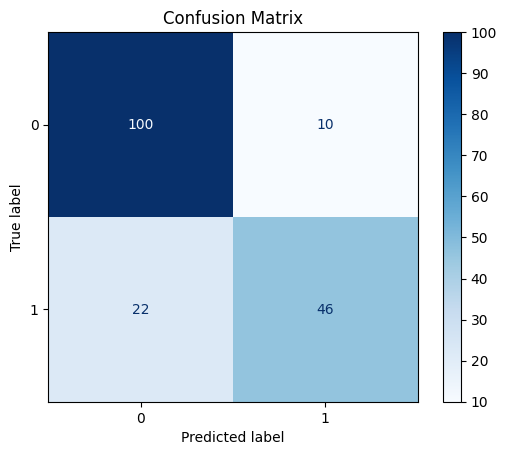

In [165]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test_s, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

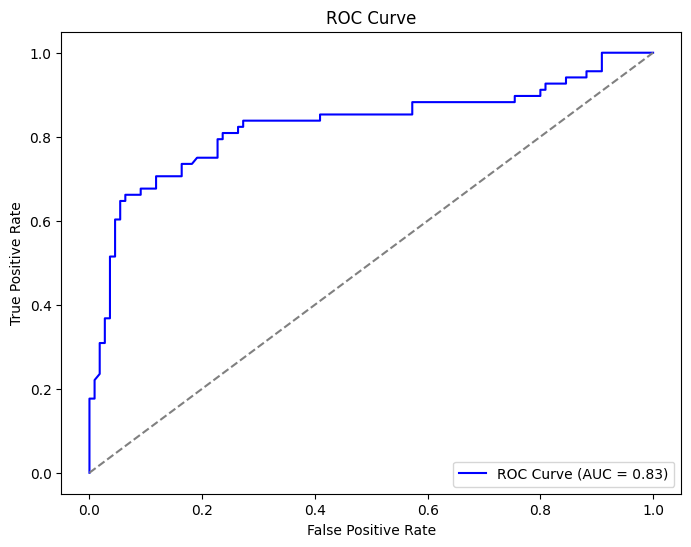

In [166]:
# Get predicted probabilities
y_prob = best_rf.predict_proba(X_test_s)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

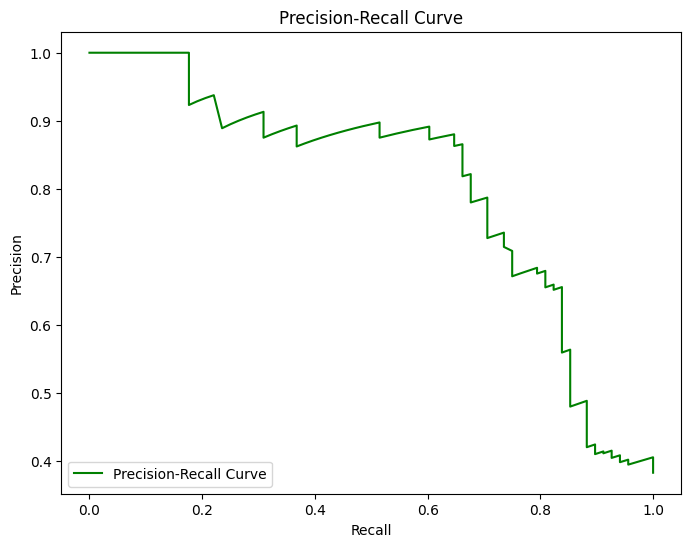

In [167]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

### 5) XGBoost

In [169]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],  
    'gamma': [0, 1, 5]
}

xgb_gs = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model
xgb_gs.fit(X_train_s, y_train)

# Print the best parameters and the best cross-validation score
print("Best parameters found: ", xgb_gs.best_params_)
print("Best cross-validation score: ", xgb_gs.best_score_)

# Get the best estimator
best_xgb = xgb_gs.best_estimator_

# Make predictions
yhat = best_xgb.predict(X_test_s)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation score:  0.8326602974490299


In [173]:
classification_report_highlighted(y_test, yhat)

🔹 Classification Report
🚨 Accuracy   : 0.8258  (Main Objective!)
✅ Precision  : 0.7761
✅ Recall     : 0.7647
✅ F1 Score   : 0.7704

🔹 Detailed Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       110
           1       0.78      0.76      0.77        68

    accuracy                           0.83       178
   macro avg       0.82      0.81      0.82       178
weighted avg       0.83      0.83      0.83       178



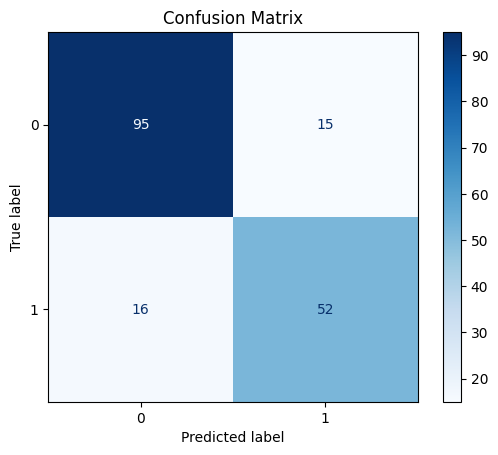

In [174]:
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test_s, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

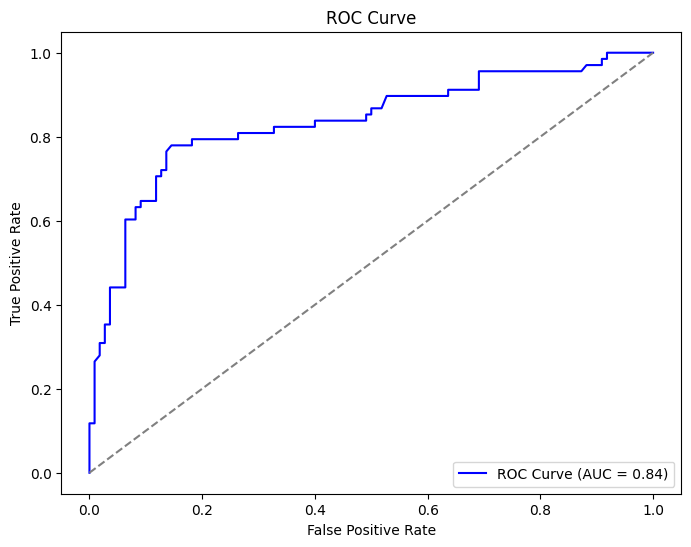

In [175]:
# Get predicted probabilities
y_prob = best_xgb.predict_proba(X_test_s)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

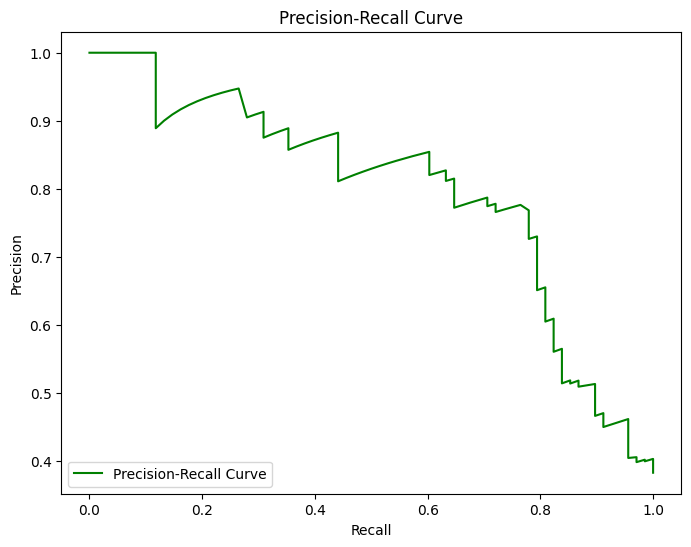

In [176]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

## g. Model Comparison

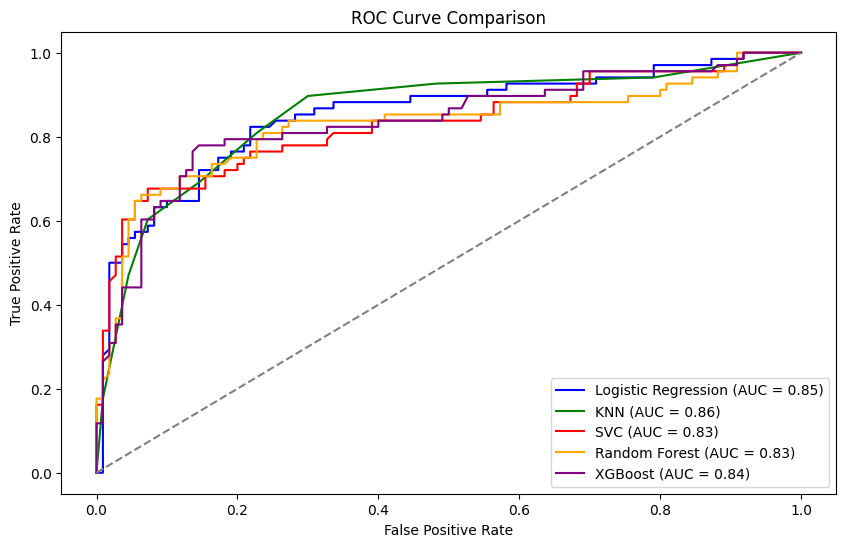

In [180]:
# Plot all ROC curves together on the same axis
plt.figure(figsize=(10, 6))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, best_lr.predict_proba(X_test_s)[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='blue', label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

# KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, best_knn.predict_proba(X_test_s)[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, color='green', label=f'KNN (AUC = {roc_auc_knn:.2f})')

# SVC
fpr_svc, tpr_svc, _ = roc_curve(y_test, best_svc.predict_proba(X_test_s)[:, 1])
roc_auc_svc = auc(fpr_svc, tpr_svc)
plt.plot(fpr_svc, tpr_svc, color='red', label=f'SVC (AUC = {roc_auc_svc:.2f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf.predict_proba(X_test_s)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='orange', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb.predict_proba(X_test_s)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, color='purple', label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

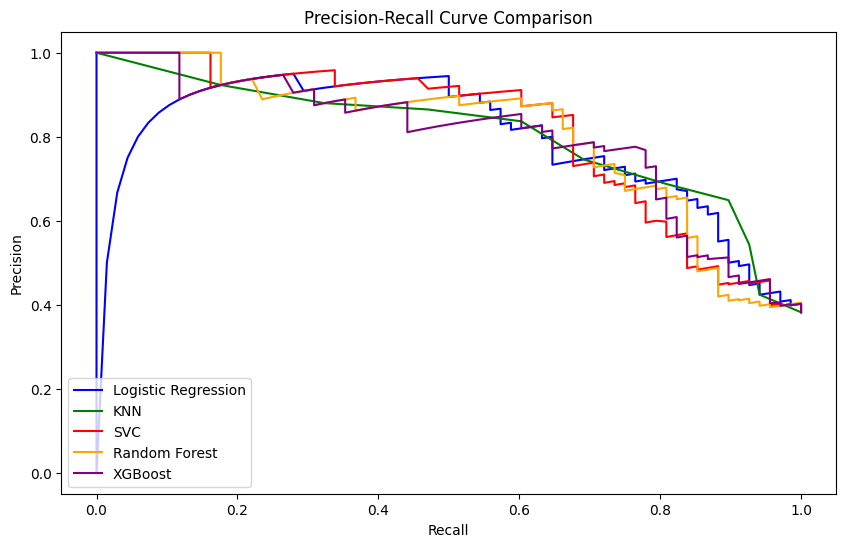

In [181]:
# Plot all Precision-Recall curves together on the same axis
plt.figure(figsize=(10, 6))

# Logistic Regression
precision_lr, recall_lr, _ = precision_recall_curve(y_test, best_lr.predict_proba(X_test_s)[:, 1])
plt.plot(recall_lr, precision_lr, color='blue', label='Logistic Regression')

# KNN
precision_knn, recall_knn, _ = precision_recall_curve(y_test, best_knn.predict_proba(X_test_s)[:, 1])
plt.plot(recall_knn, precision_knn, color='green', label='KNN')

# SVC
precision_svc, recall_svc, _ = precision_recall_curve(y_test, best_svc.predict_proba(X_test_s)[:, 1])
plt.plot(recall_svc, precision_svc, color='red', label='SVC')

# Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, best_rf.predict_proba(X_test_s)[:, 1])
plt.plot(recall_rf, precision_rf, color='orange', label='Random Forest')

# XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, best_xgb.predict_proba(X_test_s)[:, 1])
plt.plot(recall_xgb, precision_xgb, color='purple', label='XGBoost')

# Add labels, title, and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='lower left')
plt.show()

In [193]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC (ROC)": roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    }
    return metrics

# Evaluate all models
models = {
    "Logistic Regression": best_lr,
    "KNN": best_knn,
    "SVC": best_svc,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

results = {}
for model_name, model in models.items():
    results[model_name] = evaluate_model(model, X_test_s, y_test)

# Display results in a DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="AUC (ROC)", ascending=False)  # Sort by AUC (ROC)
print(results_df)

                     Accuracy  Precision    Recall  F1-Score  AUC (ROC)
KNN                  0.792135   0.746032  0.691176  0.717557   0.855013
Logistic Regression  0.797753   0.750000  0.705882  0.727273   0.852406
XGBoost              0.825843   0.776119  0.764706  0.770370   0.835762
SVC                  0.820225   0.875000  0.617647  0.724138   0.830348
Random Forest        0.820225   0.821429  0.676471  0.741935   0.826872


# 5. Submission

In [182]:
df_test = pd.read_csv('datasets/titanic/test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [183]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [184]:
# Step 1: Drop irrelevant features
df_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin'])

# Step 2: Handle missing values
# Drop rows with missing 'Embarked'
df_test = df_test.dropna(subset=['Embarked'])

# Fill missing 'Age' values with the median from the training data
df_test['Age'].fillna(df_imputate['Age'].median(), inplace=True)

# Fill missing 'Fare' values with the median from the training data
df_test['Fare'].fillna(df_imputate['Fare'].median(), inplace=True)

# Step 3: Feature Engineering
# Create 'Family_Size'
df_test['Family_Size'] = df_test['SibSp'] + df_test['Parch'] + 1

# Create 'Is_Alone'
df_test['Is_Alone'] = np.where(df_test['Family_Size'] == 1, 1, 0)

# Step 4: Feature Encoding
# Encode 'Sex'
sex_mapping = {"male": 1, "female": 0}
df_test['Sex'] = df_test['Sex'].map(sex_mapping)

# Encode 'Embarked'
embarked_mapping = {"C": 0, "Q": 1, "S": 2}
df_test['Embarked'] = df_test['Embarked'].map(embarked_mapping)

# Step 5: Drop unnecessary features
df_test = df_test.drop(columns=['SibSp', 'Parch', 'Family_Size'])

# Step 6: Scale numerical features
scaling_features = ['Age', 'Fare']
df_test[scaling_features] = s.transform(df_test[scaling_features])  # Use the scaler fitted on training data

# Final preprocessed testing data
df_test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Is_Alone
0,892,3,1,0.391613,-0.487301,1,1
1,893,3,0,1.352160,-0.504118,2,0
2,894,2,1,2.504816,-0.449614,1,1
3,895,3,1,-0.184715,-0.470401,2,1
4,896,3,0,-0.568933,-0.396884,2,0


In [194]:
# Step 7: Make predictions using the best model (XGBoost)
y_pred = best_xgb.predict(df_test.drop(columns=['PassengerId']))

# Step 8: Prepare the submission DataFrame
submission = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Survived': y_pred
})

In [195]:
# Step 9: Save the submission file
submission.to_csv('submission.csv', index=False)

# Step 10: Display the first few rows of the submission DataFrame
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [196]:
# Step 10: Save the model using joblib
import joblib
joblib.dump(best_xgb, 'best_xgboost_model.pkl')
# Load the model
loaded_model = joblib.load('best_xgboost_model.pkl')

In [204]:
# Export the submission file to Kaggle
!kaggle competitions submit -c titanic -f submission.csv -m "Message"

# Check the submission status
!kaggle competitions submissions -c titanic
# # Check the leaderboard
# !kaggle competitions leaderboard -c titanic
# # Check the leaderboard status
# !kaggle competitions leaderboard -c titanic --status

^C
fileName        date                        description  status                     publicScore  privateScore  
--------------  --------------------------  -----------  -------------------------  -----------  ------------  
submission.csv  2025-04-01 01:02:26.343000               SubmissionStatus.COMPLETE  0.74641                    


Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]2025-04-19 23:29:43,517 WARNING Retrying (Retry(total=9, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='www.googleapis.com', port=443): Read timed out. (read timeout=None)")': /upload/storage/v1/b/kaggle-competitions-submissions/o?uploadType=resumable&upload_id=AAO2VwpwWZXZRqrFBN_Ti4e4gdwbgOoe5r6V-kn2K6-gSXhGTpC6XC_XciXzLt2RLa2oS41AUuUogo-50iWUEWvjJpwJ4yx_jWuH1ISIKRFf2CI
2025-04-19 23:29:54,701 WARNING Retrying (Retry(total=8, connect=None, read=None, redirect=None, status=None)) after connection broken by 'SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:997)'))': /upload/storage/v1/b/kaggle-competitions-submissions/o?uploadType=resumable&upload_id=AAO2VwpwWZXZRqrFBN_Ti4e4gdwbgOoe5r6V-kn2K6-gSXhGTpC6XC_XciXzLt2RLa2oS41AUuUogo-50iWUEWvjJpwJ4yx_jWuH1ISIKRFf2CI
2025-04-19 23:30:07,227 WARNING Retrying (Retry(total=7, connect=None, read=None, red